# MAC0318 - Aprendizado Supervisionado - Notebook 3

Se preferir, você pode [acessar esse notebook no Google Colab](https://colab.research.google.com/drive/1STveEV3QCPPh68A6dyz510mXJaYaj8T1?usp=sharing). Lembre-se de "Copiar o notebook" para seu espaço pessoal e de transferir os arquivos de dados para lá.


*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e as bibliotecas NumPy e Tensorflow instaladas. Se você não conseguir ou quiser instalar o Tensorflow em seu computador, é possível rodá-lo na nuvem usando o [Google Colab](colab.research.google.com), como descrito na respectiva seção abaixo. 
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter e conhecimentos básicos de redes neurais convolucionais e aprendizado por descida de gradiente. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckietown` do conda antes de abrir o jupyter notebook e escolher o kernel `duckietown`, para que os requerimentos sejam satisfeitos.</red>

## Aprendizado de características

Nesta atividade, você vai construir uma rede neural convolucional que realiza segmentação de cores em imagens para extrair como características as faixas amarela e brancas da pista. Nós fizemos isso anteriormente usando simples filtros de limiar no espaço HSV. A ideia aqui é usar tais filtros para construir um conjunto de dados rotulados para aprender um filtro baseado em uma rede neural convolucional. Nessa atividade, portanto, diferentimente das atividades anteriores, a saída da rede será um vetor de alta dimensionalidade (uma imagem com a mesma dimensão da entrada).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import cv2

## Obtendo os dados

Baixe o [arquivo de imagens](https://drive.google.com/file/d/1n9uitBceCk4xXEJ7njoKWFMXpNegySDQ/view?usp=sharing) e modificar o caminho abaixo para apontá-lo para o destino correto.

In [2]:
# Mude os endereços dos arquivos conforme necessário
X = np.load('./img/data-lane-pose-estimation-images.npy', allow_pickle=True)
print('Dimensões das imagens:', X.shape) # dimensões do conjunto de imagens: número de exemplos e dimensões de cada imagem

Dimensões das imagens: (3775, 42, 80, 3)


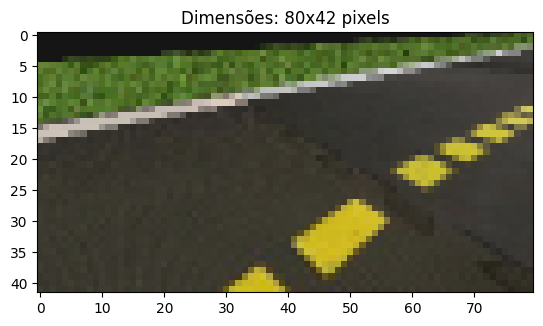

In [3]:
plt.imshow(X[0]);
plt.title(f'Dimensões: {X[0].shape[1]}x{X[0].shape[0]} pixels');

### Segmentação por cor

Vamos rotular as imagens com segmentações pelas cores amarela e branca com um filtro de intervalo no espaço HSV, e representar as segmentações em canais distintos. Essas imagens serão usadas como rótulos para o aprendizado de nosso modelo preditor.

In [4]:
# Intervalo para cor amarela 
amarelo_i = np.array([10, 80, 100], dtype=np.uint8)  # limite inferior
amarelo_s = np.array([30, 255, 255], dtype=np.uint8) # limite superior

# Intervalo para cor branca
branco_i = np.array([0, 0, 180], dtype=np.uint8)    # limite inferior
branco_s = np.array([179, 80, 255], dtype=np.uint8) # limite superior

# Criamos uma matriz N x A x L x 2 para guardar N imagens com 2 canais (amarelo e branco), 
# onde L e A são as dimensões de uma imagem (largura e altura)
Y = np.zeros((X.shape[0], X.shape[1], X.shape[2], 2), dtype=np.float32)
# Agora segmentamos cada imagem e separamos os canais
for i in range(X.shape[0]):
    # obter representação HSV
    hsv = cv2.cvtColor(X[i,:,:,:], cv2.COLOR_RGB2HSV)
    # Construir máscara dos pontos no hiperretângulo do espaço HSV especificado para cor amar ela
    Y[i,:,:,0] = cv2.inRange(hsv, amarelo_i, amarelo_s)//255 # dividimos por 255 para normalizar a saída em [0,1], o que é melhor para o aprendizado
    # Construir máscara dos pontos no hiperretângulo do espaço HSV especificado para cor branca
    Y[i,:,:,1] = cv2.inRange(hsv, branco_i, branco_s)//255

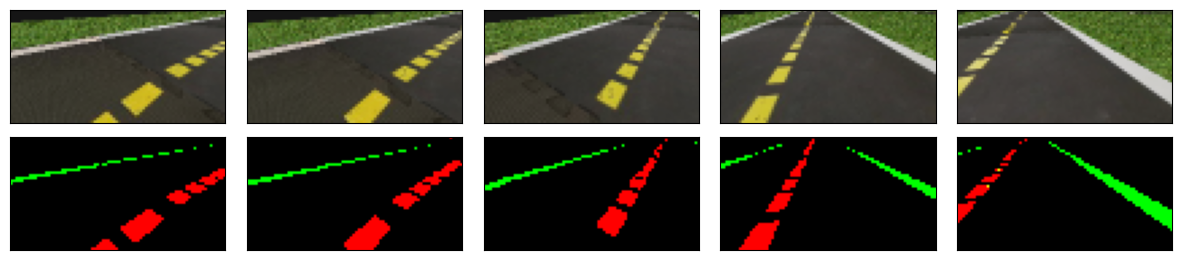

In [5]:
num_cols = 5 # número de imagens a serem exibidas
aspect_ratio = X.shape[2]/X.shape[1]
fig_width = 15
fig, ax = plt.subplots(2,num_cols,figsize=(fig_width,2*fig_width/num_cols/aspect_ratio))
for j in range(num_cols):
      k = 10*j # modifique a constante inicial 10 para mudar as imagens mostradas
      ax[0,j].imshow(X[k])
      ax[0,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
      # vamos criar uma imagem com 3 canais apenas para poder exibir em cores
      image = np.zeros((Y.shape[1],Y.shape[2],3), dtype=np.float32) 
      image[:,:,:2] = Y[k,:,:,:]
      ax[1,j].imshow(image);
      ax[1,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
fig.subplots_adjust(wspace=0.1, hspace=0.1)

### Separação Treino-Teste

Vamos separar os dados em porções para treino e teste.

In [6]:
p = 0.9 # proporção do tamanho dp subconjunto de treino
N_treino = int(p*X.shape[0] + 0.5) # quantidade de exemplos de treino

# Permutamos os índices dos exemplos
indices = np.random.permutation(X.shape[0])
id_treino, id_teste = indices[:N_treino], indices[N_treino:]
# Vamos aproveitar e normalizar as imagens de entrada para o intervalo [0,1] e transformá-las em floats com 32 bits de precisão
X_treino, X_teste = (X[id_treino,:,:,:]/255).astype(np.float32), (X[id_teste,:,:,:]/255).astype(np.float32)
Y_treino, Y_teste = Y[id_treino], Y[id_teste]

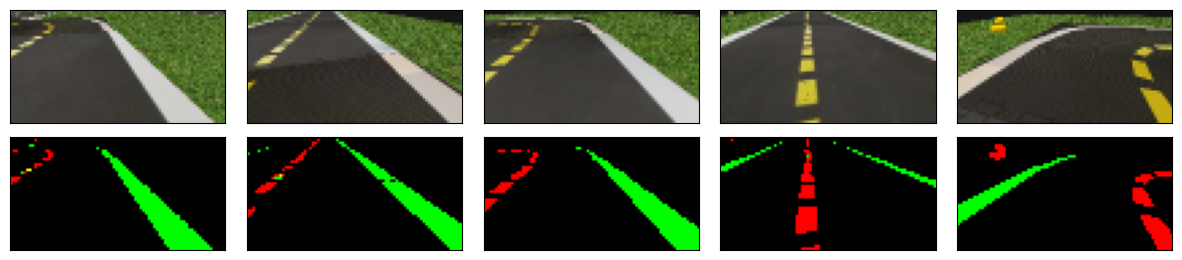

In [7]:
num_cols = 5 # número de imagens a serem exibidas
aspect_ratio = X_treino.shape[2]/X_treino.shape[1]
fig_width = 15
fig, ax = plt.subplots(2,num_cols,figsize=(fig_width,2*fig_width/num_cols/aspect_ratio))
for j in range(num_cols):
      k = 10*j # modifique a constante inicial 10 para mudar as imagens mostradas
      ax[0,j].imshow(X_treino[k])
      ax[0,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
      # vamos criar uma imagem com 3 canais apenas para poder exibir em cores
      image = np.zeros((Y_treino.shape[1],Y_treino.shape[2],3), dtype=np.float32) 
      image[:,:,:2] = Y_treino[k,:,:,:]
      ax[1,j].imshow(image);
      ax[1,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
fig.subplots_adjust(wspace=0.1, hspace=0.1)

## Treinamento

Vamos otimizar os parâmetros da rede.

In [8]:
# Verifica se GPU é acessível
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


Especificamos e compilamos uma rede com duas [camadas convolucionais](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) para realizar a segmentação de cores. Como nossa tarefa é simples (afinal, sabemos resolvê-la apenas com filtros convolucionais), duas camadas devem ser suficientes (mas você pode tornar seu modelo mais complexo se preferir depois).

In [9]:
cnn = keras.Sequential([
    keras.Input(shape=X_treino[0].shape), # camada de entrada
    # Camada convolucional com 3 filtros e kernel 3x3, com padding para manter tamanho da imagem original e passo (stride) 1
    layers.Conv2D(3, kernel_size=3, strides=(1, 1), use_bias=True, padding='same', activation='sigmoid'),
    # Camada convolucional com 2 filtros (camadas) e kernel 3x3, Vamos usar ativação sigmoidal de forma a restringir a saída em [0,1]
    layers.Conv2D(2, kernel_size=3, strides=(1, 1), use_bias=True, padding='same', activation='sigmoid')
  ])
# Vamos utilizar Adam e medir o desempenho também pelo erro absoluto médio
cnn.compile(loss='mean_squared_error', optimizer='Adam', metrics= ['mean_squared_error'])

In [10]:
# Número de parâmetros de cada camada é dado por: (número de filtros) * (número de canais da entrada) * (tamaho do kernel) + (no. de camadas se use_bias=True)
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 42, 80, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 80, 2)      │            56 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140 (560.00 B)

 Trainable params: 140 (560.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
num_epochs = 800 # número de épocas (iterações) so aprendizado

class PrintDot(keras.callbacks.Callback):
    'Mostra progresso do aprendizado.'
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print(f'{100*epoch/num_epochs:.0f}%', end='') # mostrar % de progresso a cada 50 épocas
        elif epoch % 10 == 0: print('.', end='')  # mostrar ponto a cada 10 épocas    

# Chama função de aprendizado -- isso demora alguns minutos!
hist = cnn.fit( 
    X_treino,                   # conjunto de entrada
    Y_treino,                   # conjunto de saída 
    epochs = num_epochs,        # número de épocas
    validation_split = 0.1,     # separar porção dos dados para servir como validação
    verbose = 0,                # 0, 1 ou 2, regulam a quantidade de feedback fornecido (verborragia)
    batch_size = 256,           # vamos usar amostras do conjunto de treino para economizar memória e prevenir overfitting
                                # - diminuir esse número reduz o uso de memória, porém diminui a convergência e estabilidade
    callbacks=[PrintDot()]      # Vamos usar pontinhos para indicar o progresso
)

print('100%')

0%....6%....12%....19%....25%....31%....38%....44%....50%....56%....62%....69%....75%....81%....88%....94%....100%


Vamos construir a curva de aprendizado para observar a discrepância entre a função aprendida nos conjuntos de treino e validação (e possivelmente detectar sub/sobreajuste).

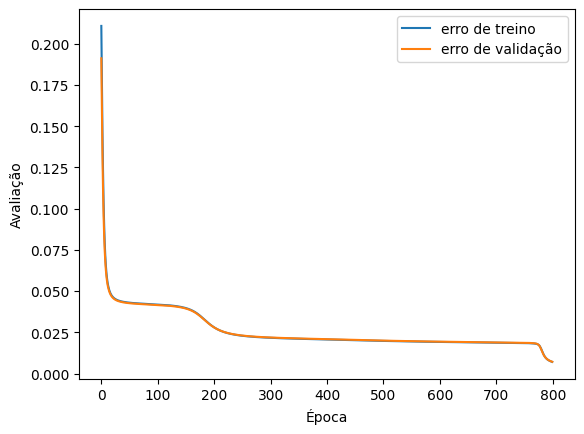

In [12]:
plt.plot(hist.epoch, hist.history['loss'], label='erro de treino');
plt.plot(hist.epoch, hist.history['val_loss'], label='erro de validação');
plt.xlabel('Época');
plt.ylabel('Avaliação');
plt.legend();

In [13]:
# Um modelo razoável deve obter mse < 0.01
cnn.evaluate(X_teste, Y_teste)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070 - mean_squared_error: 0.0070


[0.007042126730084419, 0.007042126730084419]

### E se meu preditor é ruim?

Você pode tentar melhorar a qualidade do seu preditor:

1. Realizando novamente o aprendizado a partir de outro solução inicial (aleatória)
2. Aumentanto a quantidade de camadas convolucionais da rede ou a quantidade de filtros por camada
3. Aumentando o número de épocas de treino
4. Aumentando o tamanho do _minibatch_
5. Modificando o algoritmo de aprendizado (RMSProp é outro algoritmo comumente utilizado)

In [14]:
Y_pred = cnn.predict(X_teste)
#Y_pred = tf.clip_by_value(Y_pred, clip_value_min=0, clip_value_max=1) # limitamos a saída a [0,1] imagem (caso a última camada não use sigmoide)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Vamos inspecionar visualmente o resultado das predições da rede aprendida.

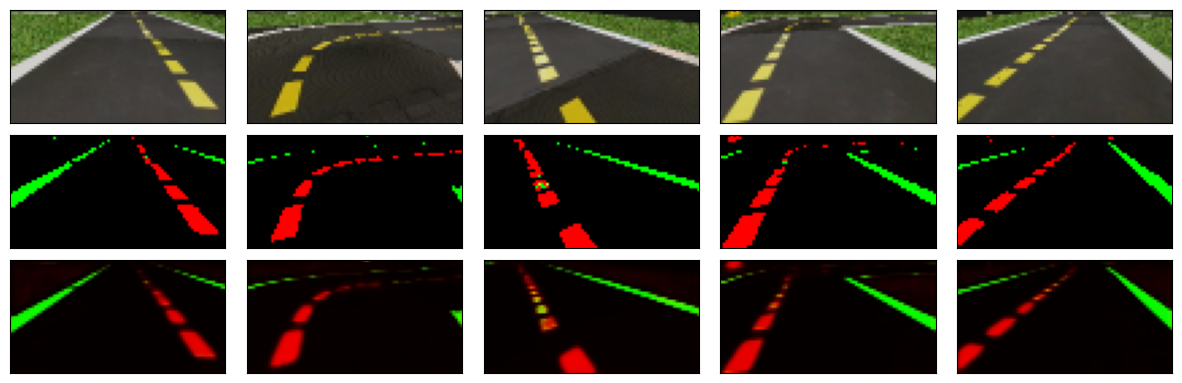

In [15]:
num_cols = 5 # número de imagens a serem exibidas
aspect_ratio = X_teste.shape[2]/X_teste.shape[1]
fig_width = 15
fig, ax = plt.subplots(3,num_cols,figsize=(fig_width,3*fig_width/num_cols/aspect_ratio))
for j in range(num_cols):
      k = np.random.randint(0,X_teste.shape[0]) # índice aleatório
      ax[0,j].imshow(X_teste[k])
      ax[0,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
      # vamos criar uma imagem com 3 canais apenas para poder exibir em cores
      image = np.zeros((Y_teste.shape[1],Y_treino.shape[2],3), dtype=np.float32) 
      image[:,:,:2] = Y_teste[k,:,:,:]
      ax[1,j].imshow(image);
      ax[1,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
      # aogra para a imagem predita pela rede
      image[:,:,:2] = Y_pred[k,:,:,:]
      ax[2,j].imshow(image);
      ax[2,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
      
fig.subplots_adjust(wspace=0.1, hspace=0.1)

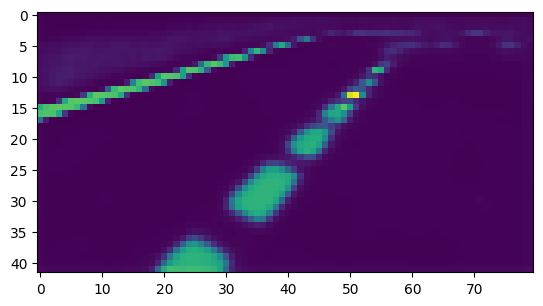

In [16]:
plt.imshow(Y_pred[0,:,:,0] + Y_pred[0,:,:,1]);